# Imports

In [1]:
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pickle
from scipy.spatial.distance import pdist
from fastcluster import linkage
import polo # 
from polo import optimal_leaf_ordering #from polo import polo
#Paper: http://bioinformatics.oxfordjournals.org/content/17/suppl_1/S22.long
from scipy.cluster import hierarchy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import LEBorm_functions as lb

%matplotlib notebook

# Data

In [2]:
file_name = '/home/lars/storage/Documents/Cortex_FISH/CountsV1-1.loom'

def loompy2data(filename, cutoff_low, cutoff_high, molecules_low):
    """
    Loom file to Panda's dataframe. Perform size and count selection on cells
    Input:
    `filename`(str): Name and path tot the Loom file
    `cutoff_low`(flt): Minimal cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `cutoff_high`(flt): Max cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `molecules_low`(int): Minimal number of molecules
    Returns:
    Panda's dataframe with cells that passed the criteria. df has cell label as column name. 
    Some gene names are corrected
    Metadata is discarded. 
    
    """
    #Read loom file and import to Pandas df
    ds = loompy.connect(filename)
    df=pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['genes']).astype(int)
    
    #Filter cell size
    for i, j in enumerate(ds.col_attrs['CellID']):
        if ds.col_attrs['CellArea'][i] < cutoff_low or ds.col_attrs['CellArea'][i] > cutoff_high:
            del df[j]
    
    #Filter total molecule count
    for i, j in enumerate(ds.col_attrs['CellID']):
        try: #not all 'CellID' are still present
            if df[j].sum() < molecules_low:
                del df[j]
        except Exception:
            pass
        
    #Filter bad hybridiztion4 (out of focus imaging) and repeat Tbr1
    bad_data = ['Hybridization4_Cnr1', 'Hybridization4_Plp1', 'Hybridization4_Vtn', 'Hybridization11_Tbr1']
    for i in bad_data:
        df.drop(i, inplace=True)
     
    #Change incorrect names Tmem6-->Tmem2 and Kcnip-->Kcnip2
    df= df.rename({'Hybridization11_Tmem6': 'Hybridization11_Tmem2', 'Hybridization12_Kcnip': 'Hybridization12_Kcnip2'})
    
    print('Selected cells with  {}>size<{} and a minimum molecule count of {} molecules'.format(cutoff_low, cutoff_high, molecules_low))
    print('Change incorrect names Tmem6-->Tmem2 and Kcnip-->2')
    return df

    
df_fish = loompy2data(file_name,2000, 60000, 20)
df_fish.shape

Selected cells with  2000>size<60000 and a minimum molecule count of 20 molecules
Change incorrect names Tmem6-->Tmem2 and Kcnip-->2


(35, 6036)

In [3]:
gene_sort = ['Gad2', 'Slc32a1', 'Crhbp', 'Kcnip2', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',             
             'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 
             'Aldoc', 'Gfap', 'Serpinf1', 'Mfge8', 
             'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2',  'Ctps',  'Klk6', 'Anln',   
             'Mrc1', 'Hexb', 
             'Ttr', 
             'Foxj1', 
             'Vtn', 'Flt1', 'Apln', 'Acta2',  'Lum'] 

gene_sort_wrong = ['Gad2', 'Slc32a1', 'Crhbp', 'Kcnip', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh', 
             'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 
             'Aldoc', 'Gfap', 'Serpinf1', 'Mfge8', 
             'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem6',  'Ctps',  'Klk6', 'Anln',   
             'Mrc1', 'Hexb', 
             'Ttr', 
             'Foxj1', 
             'Vtn', 'Flt1', 'Apln', 'Acta2',  'Lum'] 


gene_sort_fish = ['Hybridization2_Gad2', 'Hybridization12_Slc32a1', 'Hybridization10_Crhbp', 'Hybridization12_Kcnip2', 'Hybridization13_Cnr1', 'Hybridization6_Vip', 'Hybridization5_Cpne5', 'Hybridization8_Pthlh',  'Hybridization10_Crh', 
'Hybridization1_Tbr1', 'Hybridization9_Lamp5', 'Hybridization7_Rorb', 'Hybridization11_Syt6',
'Hybridization1_Aldoc', 'Hybridization2_Gfap', 'Hybridization8_Serpinf1', 'Hybridization3_Mfge8',
 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization8_Pdgfra', 'Hybridization6_Bmp4','Hybridization6_Itpr2','Hybridization11_Tmem2', 'Hybridization7_Ctps','Hybridization5_Klk6','Hybridization9_Anln',
 'Hybridization3_Mrc1','Hybridization3_Hexb', 
 'Hybridization13_Ttr',
 'Hybridization1_Foxj1',
 'Hybridization12_Vtn',
 'Hybridization2_Flt1',
 'Hybridization10_Apln',
 'Hybridization5_Acta2',
 'Hybridization9_Lum']


#Make conversion dictionary with gene names and corresponding HybridizationX_geneY names

gene_name_conversion = {}

for i in gene_sort:
    for j in df_fish.index:
        if j.endswith(i):
            gene_name_conversion[j] =i
            
gene_name_conversion_reverse = dict((v,k) for k,v in gene_name_conversion.items())
            

In [4]:
#Open object properties
obj_prop = pickle.load(open("ObjProp_dict.pkl", 'rb'))

#Load cell ID and XY coordinates into a list
coord_list = []
for i in obj_prop:
    coord_list.append([i, obj_prop[i]['obj_centroid'][0], obj_prop[i]['obj_centroid'][1]])
    
#Place cell ID and X and Y coordinates into dataframe
coord_df = pd.DataFrame(coord_list, columns=['Cell_ID', 'X', 'Y']).set_index('Cell_ID').T
coord_df = coord_df.loc[:,df_fish.columns]

In [5]:
df_fish = df_fish.loc[gene_sort_fish,:]

#Transform data
X = df_fish.values.astype(np.float64)
    #Sqrt normalize
X_sqrt = np.sqrt(X)
    #Mean normalize
X_norm = X.sum(0).mean() * (X/X.sum(0))
    #Log transform
X_log = np.log2(X_norm+1)

    #Build dataframes of normalized and log transformed data
df_fish_sqrt = pd.DataFrame(data=X_sqrt, columns=df_fish.columns, index=df_fish.index)
df_fish_norm = pd.DataFrame(data=X_norm, columns=df_fish.columns, index=df_fish.index)
df_fish_log = pd.DataFrame(data=X_log, columns=df_fish.columns, index=df_fish.index)

#Devide by size
area_df_fish = np.array([(np.sqrt(obj_prop[c]['obj_area'])*0.065)**2 for c in df_fish.columns])
X_size = X/area_df_fish
    #Sqrt normalize
X_size_sqrt = np.sqrt(X_size)
    #Mean normalize
X_size_norm = X_size.sum(0).mean() * (X_size/X_size.sum(0))
    #Log transform
X_size_log = np.log2(X_size_norm+1)

    #Build dataframes of normalized and log transformed data
df_fish_size_sqrt = pd.DataFrame(data=X_size_sqrt, columns=df_fish.columns, index=df_fish.index)
df_fish_size_norm = pd.DataFrame(data=X_size_norm, columns=df_fish.columns, index=df_fish.index)
df_fish_size_log = pd.DataFrame(data=X_size_log, columns=df_fish.columns, index=df_fish.index)


#Calculate the fold change dataframe
df_fish_fc = df_fish.loc[gene_sort_fish,:]
mean_expression_for_fc =  df_fish.loc[gene_sort_fish,:].T.mean()
df_fish_fc = df_fish_fc.divide(mean_expression_for_fc, axis='rows')

X_fc = df_fish_fc.values

# Test dataset

In [6]:
olig_id = pickle.load(open("oligodendrocytes.p", 'rb'))
df_olig = df_fish_size_sqrt.loc[:,olig_id]

In [7]:
df_olig.head(5)

,994,2872,5434,4234,2913,3230,2288,4495,4123,5302,...,6581,3075,1024,2314,1101,2808,3251,2757,1228,1234
Hybridization2_Gad2,0.199621,0.117908,0.202330,0.210055,0.204283,0.215823,0.185290,0.568956,0.696480,0.233374,...,0.275208,0.433273,0.409246,0.377686,0.349566,0.000000,0.124412,0.157064,0.224959,0.36652
Hybridization12_Slc32a1,0.000000,0.000000,0.116815,0.105027,0.000000,0.000000,0.000000,0.000000,0.372284,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.180515,0.105712,0.000000,0.222121,0.000000,0.00000
Hybridization10_Crhbp,0.115251,0.117908,0.286138,0.000000,0.166796,0.000000,0.000000,0.000000,0.322407,0.000000,...,0.000000,0.000000,0.105667,0.000000,0.180515,0.105712,0.000000,0.000000,0.000000,0.00000
Hybridization12_Kcnip2,0.000000,0.166747,0.165202,0.000000,0.000000,0.000000,0.106977,0.164243,0.372284,0.000000,...,0.275208,0.000000,0.105667,0.000000,0.156331,0.183098,0.000000,0.157064,0.000000,0.00000
Hybridization13_Cnr1,0.199621,0.204223,0.233630,0.148531,0.166796,0.000000,0.354803,0.284478,0.263245,0.104368,...,0.000000,0.000000,0.236278,0.000000,0.156331,0.211424,0.087972,0.192363,0.000000,0.00000


In [8]:
def cluster_binarity(df, labels, cluster_of_interest, cutoff_expression, cutoff_percentage):
    """
    Calculates the percentage of cells, of a given cluster_of_interest in a df, 
    that have an expression above the cutoff_expression. It returns a pandas 
    Series with the percentages and it returns the names of the genes that have
    a percentage higher than the cutoff_percentage.
    Input:
    `df`(pandas dataframe): df of the cells that were clusterd.
    `labels`(numpy array): Cluster labels of the clustering, in same order as df.
    `cluster_of_interest`(int): Cluster of interest from the labels.
    `cutoff_expression`(float): used to make a binarization and is the same for
        all genes. Data normalization is very important!
    `cutoff_percentage`(float): Percentage of cells that need to be 'positive'
        in the cluster. 
    Returns:
    *Pandas series with the percentages for all genes
    *List of names of genes with a percentage higher than the cutoff_percentage
    
    """
    filt = labels == cluster_of_interest
    df = df.loc[:,filt]
    
    #Calculate percentage of cells that are above the cutoff
        #Percentage of cells that are above cutoff_expression
    positive = (df[df>cutoff_expression].T.count() / df.shape[1]) * 100
        #Genes that are considered positive above the cutoff_percentage
    positive_genes = [positive.index[i] for i,n in enumerate(positive) if n>cutoff_percentage]
    return positive, positive_genes

In [26]:
def gini(array):
    #Function from:
    #https://github.com/oliviaguest/gini/blob/master/gini.py
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

Order of clusters: [0, 1]


<IPython.core.display.Javascript object>


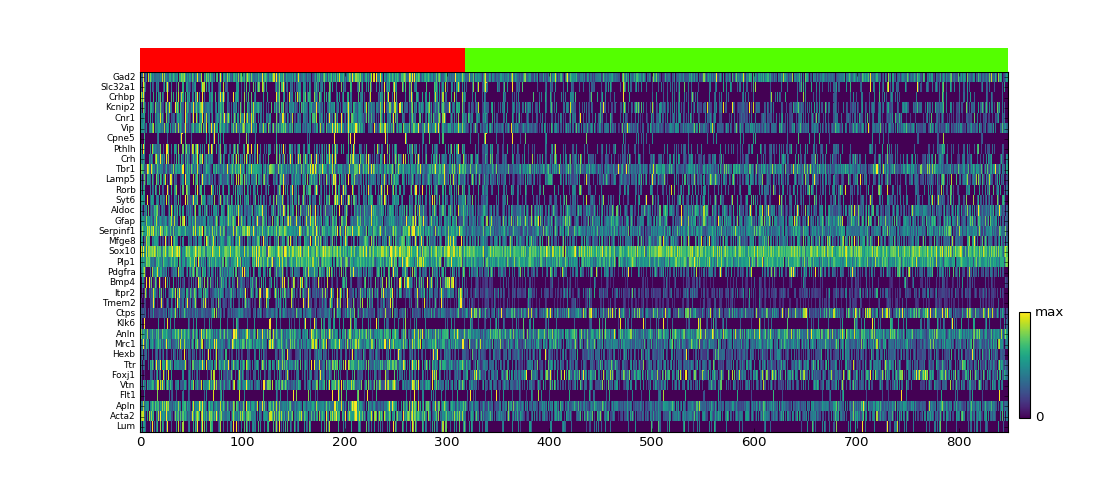

(35, 848)
848
['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1']




In [44]:
split = AgglomerativeClustering(n_clusters=2).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[1])
    print('\n')

Order of clusters: [0, 1, 2]


<IPython.core.display.Javascript object>


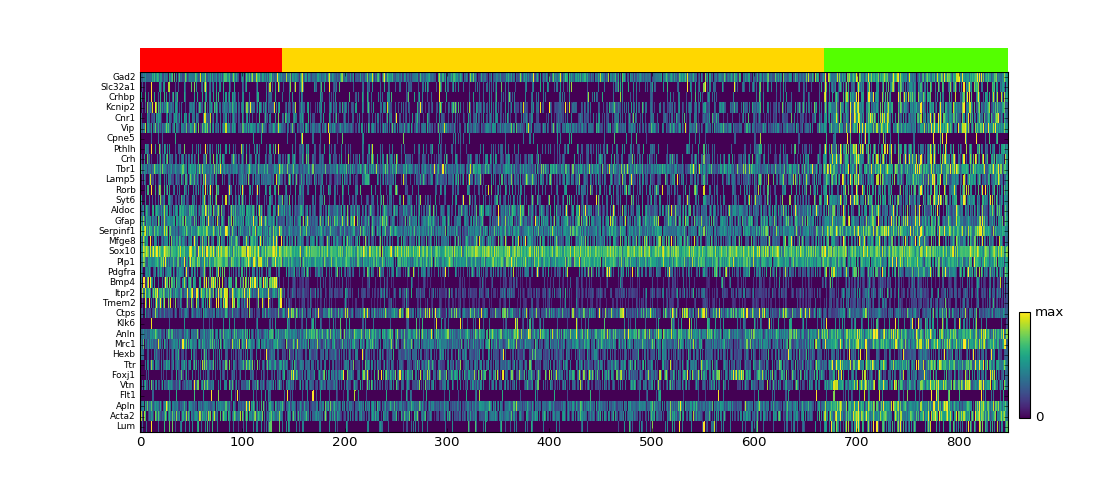

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']




In [32]:
split = AgglomerativeClustering(n_clusters=3).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 1, 0, 2]


<IPython.core.display.Javascript object>


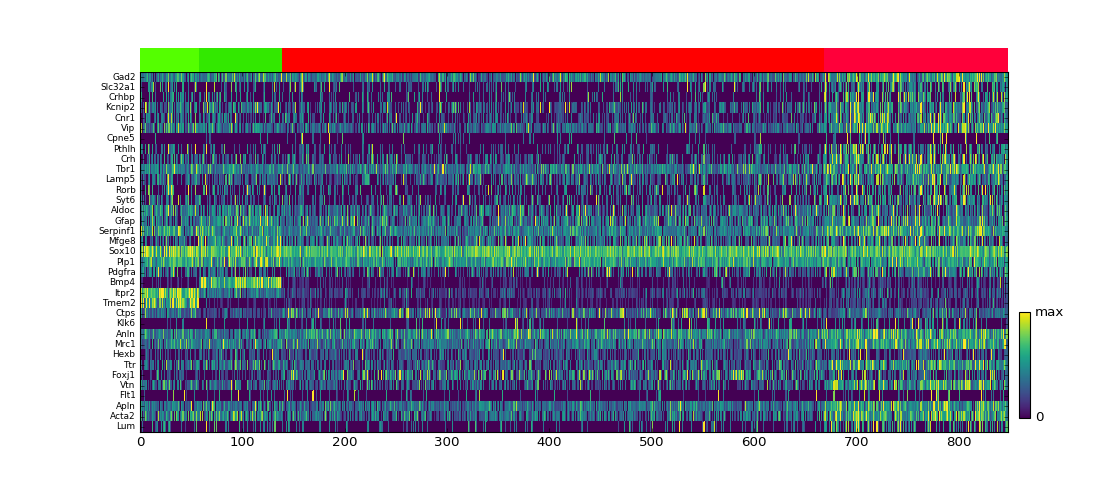

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']




In [33]:
split = AgglomerativeClustering(n_clusters=4).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 4, 1, 2, 0]


<IPython.core.display.Javascript object>


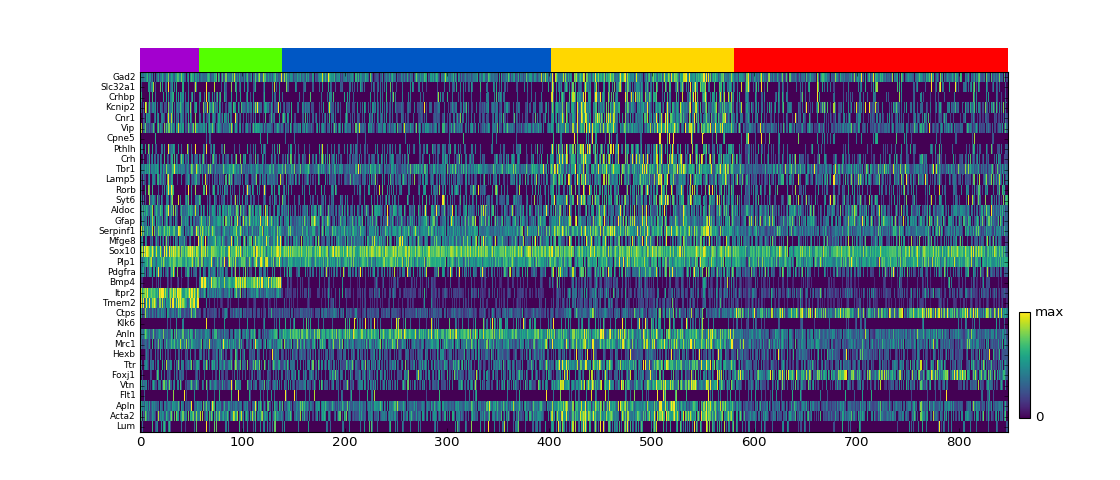

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization7_Sox10', 'Hybridization13_Plp1']




In [34]:
split = AgglomerativeClustering(n_clusters=5).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 0, 2, 1, 5, 4]


<IPython.core.display.Javascript object>


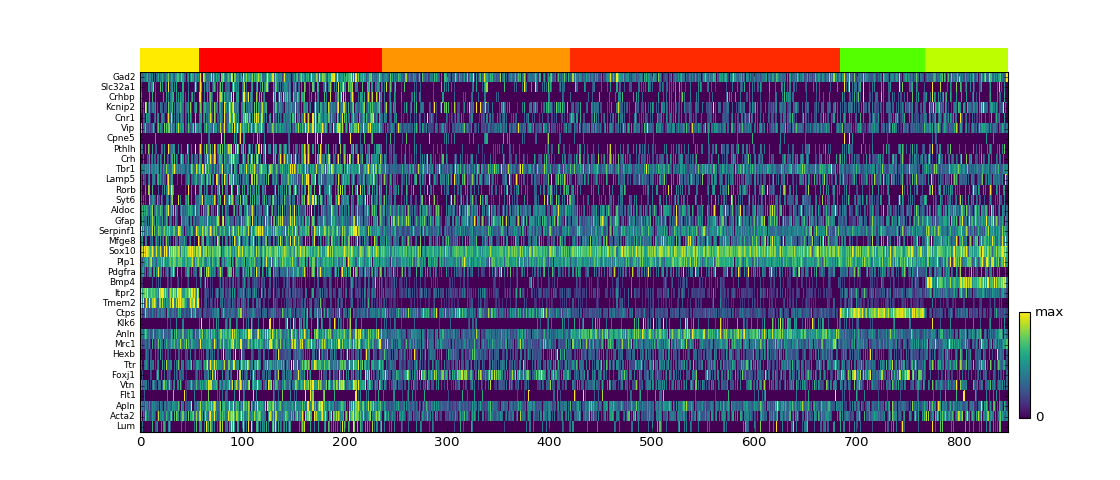

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']
0.530242270774


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']
0.422257299666


['Hybridization7_Sox10', 'Hybridization13_Plp1']
0.607426945274


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']
0.614937969074


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps']
0.597309059726


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']
0.542729304767




In [35]:
split = AgglomerativeClustering(n_clusters=6).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print(gini(np.array(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[0])))
    print('\n')

Order of clusters: [4, 2, 0, 5, 1, 6, 3]


<IPython.core.display.Javascript object>


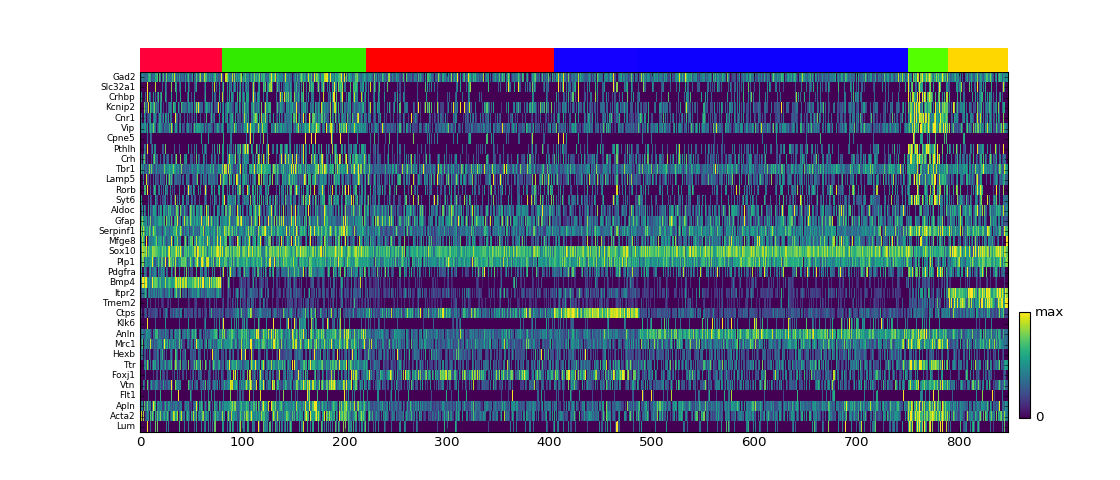

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization2_Gad2', 'Hybridization6_Vip', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization9_Anln', 'Hybridization3_Mrc1', 'Hybridization5_Acta2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']




In [36]:
split = AgglomerativeClustering(n_clusters=7).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [8, 10, 18, 15, 5, 12, 3, 17, 4, 7, 6, 11, 2, 0, 1, 14, 9, 19, 16, 13]


<IPython.core.display.Javascript object>


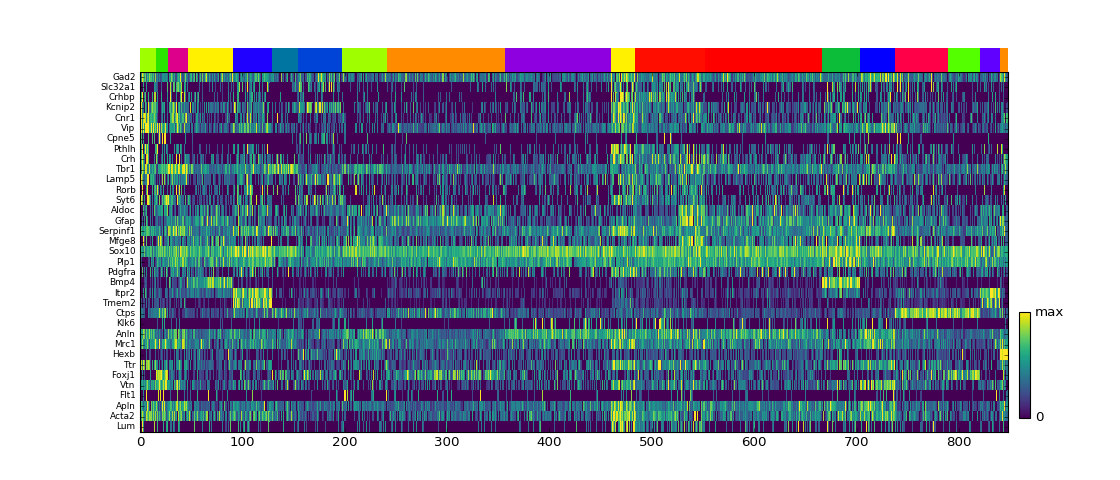

(35, 848)
848
['Hybridization2_Gad2', 'Hybridization6_Vip', 'Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization9_Anln', 'Hybridization3_Mrc1', 'Hybridization5_Acta2']
0.449219686818


['Hybridization6_Vip', 'Hybridization1_Tbr1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps', 'Hybridization1_Foxj1', 'Hybridization12_Vtn']
0.455205810058


['Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln', 'Hybridization10_Apln']
0.434406437615


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']
0.608578180831


['Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2', 'Hybridization9_Anln']
0.510635869759


['Hybridization1_Tbr1', 'Hybridization7_Sox10']
0.659535535397


['Hybridization7_Sox10', 'Hybridization13_Plp1']
0.606648694344


['Hybridization7_Sox10', 'H

In [30]:
split = AgglomerativeClustering(n_clusters=20).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[1])
    print(gini(np.array(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[0])))
    print('\n')

# Iterative clustering

In [197]:
clusters_it16 = {'Level0_' : [df_olig.columns] } #np.zeros((1,len(df_olig.columns)))]
level_cells = {}

for i in range(4):
    for parent in [ k for k,v in clusters_it16.items() if 'Level{}'.format(i) in k]:
        #cluster parent
        cells = clusters_it16[parent][0]
        df_to_split = df_olig.loc[:, cells]
        split = AgglomerativeClustering(n_clusters=2).fit(df_to_split.T)
        #update parent level
        clusters_it16[parent].append(split.labels_)

        #Children
            #Update child cluster 0 
        code0 = parent.split('_')[1] + '0'
        filt = split.labels_ == 0
        clusters_it16['Level{}_{}'.format(i+1, code0)] = [df_to_split.columns[filt]]
            #Update child cluster 1
        code1 = parent.split('_')[1] + '1'
        filt = split.labels_ == 1
        clusters_it16['Level{}_{}'.format(i+1, code1)] = [df_to_split.columns[filt]]  
    
    #Sort the cells based on cluster and put them in a list
    level_cells['Level{}'.format(i)] = []
    for level in [ k for k,v in clusters_it16.items() if 'Level{}'.format(i) in k]:
        print(level)
        level_cells['Level{}'.format(i)].extend(clusters_it16[level][0])



Level0_
Level1_1
Level1_0
Level2_01
Level2_10
Level2_11
Level2_00
Level3_111
Level3_000
Level3_101
Level3_110
Level3_001
Level3_010
Level3_011
Level3_100


<IPython.core.display.Javascript object>


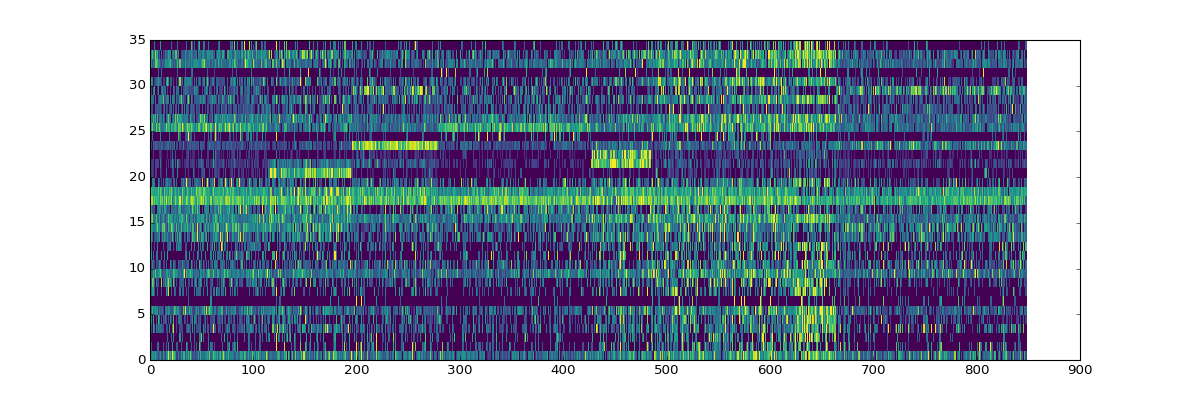

In [202]:
plt.figure(figsize=(15,5))

z = df_olig.loc[:, level_cells['Level3']]
z = z.values
z = z/np.percentile(z, 99, 1)[:,None]

plt.pcolor(z, cmap='viridis', vmax=1)

In [ ]:
lb.heat_map(df_olig, )

In [196]:
df_olig

,994,2872,5434,4234,2913,3230,2288,4495,4123,5302,...,6581,3075,1024,2314,1101,2808,3251,2757,1228,1234
Hybridization2_Gad2,0.199621,0.117908,0.202330,0.210055,0.204283,0.215823,0.185290,0.568956,0.696480,0.233374,...,0.275208,0.433273,0.409246,0.377686,0.349566,0.000000,0.124412,0.157064,0.224959,0.366520
Hybridization12_Slc32a1,0.000000,0.000000,0.116815,0.105027,0.000000,0.000000,0.000000,0.000000,0.372284,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.180515,0.105712,0.000000,0.222121,0.000000,0.000000
Hybridization10_Crhbp,0.115251,0.117908,0.286138,0.000000,0.166796,0.000000,0.000000,0.000000,0.322407,0.000000,...,0.000000,0.000000,0.105667,0.000000,0.180515,0.105712,0.000000,0.000000,0.000000,0.000000
Hybridization12_Kcnip2,0.000000,0.166747,0.165202,0.000000,0.000000,0.000000,0.106977,0.164243,0.372284,0.000000,...,0.275208,0.000000,0.105667,0.000000,0.156331,0.183098,0.000000,0.157064,0.000000,0.000000
Hybridization13_Cnr1,0.199621,0.204223,0.233630,0.148531,0.166796,0.000000,0.354803,0.284478,0.263245,0.104368,...,0.000000,0.000000,0.236278,0.000000,0.156331,0.211424,0.087972,0.192363,0.000000,0.000000
Hybridization6_Vip,0.230502,0.235816,0.369402,0.148531,0.288899,0.176219,0.106977,0.000000,0.372284,0.276131,...,0.000000,0.216636,0.298871,0.188843,0.361030,0.472758,0.196712,0.293839,0.318140,0.211610
Hybridization5_Cpne5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hybridization8_Pthlh,0.000000,0.000000,0.202330,0.000000,0.000000,0.000000,0.000000,0.000000,0.455953,0.000000,...,0.000000,0.000000,0.105667,0.000000,0.180515,0.105712,0.087972,0.000000,0.000000,0.000000
Hybridization10_Crh,0.115251,0.204223,0.233630,0.105027,0.117943,0.000000,0.106977,0.000000,0.263245,0.147598,...,0.000000,0.108318,0.380988,0.267064,0.238799,0.105712,0.087972,0.000000,0.000000,0.211610
Hybridization1_Tbr1,0.552725,0.263650,0.629069,0.257263,0.514100,0.278626,0.239208,0.232275,0.492486,0.608564,...,0.476675,0.216636,0.559137,0.000000,0.372142,0.366197,0.248824,0.248339,0.000000,0.457130


In [186]:
level_cells = {}
for i in range(4):
    level_cells['Level{}'.format(i)] = []
    for level in [ k for k,v in clusters_it16.items() if 'Level{}'.format(i) in k]:
        print(level)
        level_cells['Level{}'.format(i)].extend(clusters_it16[level][0])

Level0_
Level1_1
Level1_0
Level2_01
Level2_10
Level2_11
Level2_00
Level3_111
Level3_000
Level3_101
Level3_110
Level3_001
Level3_010
Level3_011
Level3_100


In [191]:
len(level_cells['Level3'])

848

In [184]:
test = []
test.extend(clusters_it16['Level1_0'][0])
test.extend(clusters_it16['Level1_1'][0])

In [185]:
test

['2872',
 '5434',
 '2913',
 '4123',
 '2630',
 '2673',
 '2955',
 '5396',
 '3064',
 '4147',
 '2582',
 '1367',
 '4206',
 '5427',
 '2706',
 '1520',
 '2571',
 '2638',
 '7629',
 '1098',
 '1055',
 '4293',
 '1005',
 '2487',
 '2584',
 '1215',
 '1049',
 '2750',
 '1053',
 '1492',
 '2529',
 '2712',
 '3232',
 '11',
 '1362',
 '5420',
 '4237',
 '4485',
 '1144',
 '2658',
 '4439',
 '7311',
 '1029',
 '2951',
 '191',
 '1065',
 '4488',
 '6323',
 '2636',
 '4440',
 '7854',
 '2544',
 '2633',
 '3037',
 '5416',
 '3238',
 '2580',
 '4150',
 '1467',
 '3081',
 '1084',
 '3196',
 '3174',
 '5297',
 '2676',
 '845',
 '4164',
 '2600',
 '6419',
 '1088',
 '971',
 '5358',
 '3785',
 '6426',
 '4171',
 '1045',
 '2937',
 '4129',
 '5401',
 '2518',
 '2835',
 '2521',
 '2595',
 '5395',
 '2873',
 '1170',
 '1025',
 '2981',
 '1089',
 '3227',
 '3015',
 '2620',
 '2649',
 '2988',
 '5336',
 '941',
 '2982',
 '2124',
 '3225',
 '2939',
 '3009',
 '3024',
 '4245',
 '4225',
 '1016',
 '4249',
 '2629',
 '5361',
 '2968',
 '7891',
 '1503',
 '2666'

In [ ]:
def iterative_clustering(df):
    #Make the label table
    initial_labels = np.array(['L0_C0' for i in range(len(df_fish.columns))]).reshape((1,len(df_fish.columns)))
    label_tree = pd.DataFrame(data=initial_labels, columns=df.columns)
    
    current_level = 0
    offset = 0
    
    #Iterate through the current sub clusters
    for superclust in np.unique(label_tree.loc[current_level]):
        current_level += 1
        print(superclust)
        filt = label_tree.loc[current_level] == superclust
        df_to_clust = df.loc[:,filt]
        
        #Split cells into two clusters
        split = AgglomerativeClustering(n_clusters=2).fit(df_to_clust.T)
        
        #Update the label_tree with new temporary labels (Format: Level X _ Cluster Y --> LxCy)
        for i, cell in enumerate(df_to_clust.columns):
            cluster_id = 'L{}_C{}'.format((current_level), (split.labels_[i]+offset))
            label_tree.loc[current_level, cell] = cluster_id